### import os
import math
import requests
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cufflinks as cf
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected = True)
cf.go_offline()

In [3]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Round 2/Round 2 CSV/Room 5308")
room5308 = pd.read_excel("Room 5308 Combined.xlsx", index_col = 0)

# PMV from UC Berkeley Comfort Model (Formula To Use)

In [63]:
#Input Unit of Measure

    # airTemp = Fahrenheit
    # relativeHumidity = Whole Number (eg. 85)
    # Mean Radiant Temp = Fahrenheit
    # airSpeed = Miles per Hour
    # cloValue = Clo
    # metRate = Met

def PMV(airTemp, relativeHum, MRT, airSpeed, cloValue, metRate):
    
    # Returns PMV
    # ta, airTemp, Celcius
    # tr, mean radiant temperature, Celcius
    # vel, relative air velocity, (m/s)
    # rh, relative humidity (%) Used only this way to input humidity level
    # met, metabolic rate, (met)
    # clo, clothing (clo)
    # wme, external work, normally around 0
    
    
    #Conversion of units of measure
    
    ta = (airTemp - 32)/1.8
    tr = (MRT - 32)/1.8
    vel = airSpeed * .44704   
    pa = relativeHum * 10 * math.exp(16.6536 - 4030.183 / (ta + 235))
    
    #Thermal Insulation of the clothing in M2K/W
    
    icl = 0.155 * cloValue
    
    #Metabolic Rate in W/M2
    
    m = metRate * 58.15
    
    #External Work in W/M2
    
    w = .001 * 58.15
    
    #Internal heat production of the human body
    
    mw = m - w
    if icl <= .078:
        fcl = 1 + (1.29 * icl)
    else:
        fcl = 1.05 + (.645 * icl)
    
    #Heat transfer coefficient by forced convection
    
    hcf = 12.1 * np.sqrt(vel)
    taa = ta + 273
    tra = tr + 273
    tcla = taa + (35.5 - ta) / (3.5 * icl + 0.1)
    p1 = icl * fcl
    p2 = p1 * 3.96
    p3 = p1 * 100
    p4 = p1 * taa
    p5 = 308.7 - .028 * mw + p2 * math.pow(tra/100,4)
    xn = tcla / 100
    xf = tcla / 50
    eps = .00015
    
    n = 0
    while (np.abs(xn - xf) > eps):
        xf = (xf + xn) / 2
        hcn = 2.38 * math.pow(np.abs(100 * xf - taa), .25)
        if hcf > hcn:
            hc = hcf
        else:
            hc = hcn
        
        xn = (p5 + p4 * hc - p2 * math.pow(xf,4)) / (100 + p3 * hc)
        
        n+=1
        
        if n > 150:
            print("Max iterations exceeded")
            return 1
    
    tcl = 100 * xn - 273
    
    # Heat loss diff through skin
    
    hl1 = 3.05 * .001 * (5733 - (6.99 * mw) - pa)
    
    # Heat loss by sweating
    
    if mw > 58.15:
        hl2 = .42 * (mw - 58.15)
    else:
        hl2 = 0
    
    # Latent respiration heat loss
    
    hl3 = 1.7 * .00001 * m * (5867 - pa)
    
    # Dry respiration heat loss
    
    hl4 = .0014 * m * (34 - ta)
    
    # Heat loss by radiation
    
    hl5 = 3.96 * fcl * (math.pow(xn, 4) - math.pow(tra/100, 4))
    
    # Heat loss by convection
    
    hl6 = fcl * hc * (tcl - ta)
    
    ts = .303 * np.exp(-0.036 * m) + .028

    pmv = ts * (mw - hl1 - hl2 - hl3 - hl4 - hl5 - hl6)    
    
#     pmv = round(pmv,1)
    
    return(np.round(a = pmv, decimals = 1))

# PMV From Excel Macro (Do Not Use)

#### Additional functions necessary for PMV calculations

In [116]:
# Function to calculate saturation pressure of water vapor
def SatPress(TArg):
    
    c1 = -5674.5359
    c2 = -.51523058
    c3 = -0.009677843
    c4 = 6.2215701e-07
    c5 = 2.0747825e-09
    c6 = -9.484024e-13
    c7 = 4.1635019
    c8 = -5800.2206
    c9 = -5.516256
    c10 = -0.048640239
    c11 = 4.1764768e-05
    c12 = -1.4452093e-08
    c13 = 6.5459673
    
    T = (TArg + 459.67) * .555556 
    
    if T < 273.15:
        kPa = np.exp(c1 / T + c2 + T * c3 + T * T * (c4 + T * (c5 + c6 * T)) + c7 * np.log(T))
    else:
        kPa = np.exp(c8 / T + c9 + T * (c10 + T * (c11 + T * c12)) + c13 * np.log(T))
    
    satPress = kPa / 101.325
    
    return(satPress)
    

In [115]:
# Function to calculate humidity ratio from temperature and relative humidity
def HumRatRH(TArg, RH, PAtm):
    pw = SatPress(TArg) * RH / 100 
    humRat = (.62198 * pw) / (PAtm - pw)
    return(humRat)
    

#### Predicted Mean Vote Inputs

airTemp / TA / Air Temperature in Ferinheight

MRT / TR / Mean Radiant Temperature in Ferinheight

airSpeed / V / Bulk Air Velocity in Miles per Hour

cloValue / Icl / Insulation Level in Clo

metRate / Met / Metabolic Rate in Mets

#### Assumptions

Atmospheric Pressure = .99

In [500]:
def excel(airTemp, relativeHum, MRT, airSpeed, cloValue, metRate):
     
    PAtm = .99
    WA = HumRatRH(airTemp, relativeHum, PAtm)
    
    TA = (airTemp - 32)/1.8
    TR = (MRT - 32)/1.8
    
    V = airSpeed * .44704
    
    work = 0
    M = metRate * 58.15
    MW = M - work
    Rcl = cloValue * .155
    fcl = 1.05 + (.1 * cloValue)
    hc = 12.1 * (V ** .5)
    hr = 4.2
    TSk = 35.7 - (MW * .0275)
    qSweat = .42 * (MW - 58.15)
    
    WSatSK = HumRatRH(TSk * 1.8 + 32, 1, PAtm)
    
    qRespSen = .0014 * M * (34 - TA)
    qRespLat = 2.78 * M * (.0365 - WA)
    qEvapDiff = 491 * (WSatSK - WA)
    
    Tcl = ((TSk + Rcl * fcl * (hc *TA + hr *TR)) / (1 + Rcl * fcl * (hc+hr)))
    
    if Tcl < TA:
        Tcl = TA
        hc1 = 2.38 * (Tcl - TA) ** .25
        hc2 = 12.1 * (V ** .5)
        if hc1 > hc2:
            hc = hc1
        else:
            hc = hc2
    
    Tcl = ((TSk + Rcl * fcl * (hc *TA + hr *TR)) / (1 + Rcl * fcl * (hc+hr)))
    
    L = MW - fcl * hr * (Tcl - TR) - fcl * hc * (Tcl - TA) - qEvapDiff - qSweat - qRespSen - qRespLat
    
    PMV = L * (.303 * np.exp(-.036 * M) + .028)
    
    if PMV > 3.0:
        PMV = 3.0
    elif PMV < -3.0:
        PMV = -3.0
    
    return(PMV)

# PMV from ASHRAE 55 (Do Not Use)

In [501]:
def ashrae(airTemp, relativeHum, MRT, airSpeed, cloValue, metRate):
    
    TA = (airTemp - 32)/1.8
    TR = (MRT - 32)/1.8
    
    VEL = airSpeed * .44704
        
    PA = relativeHum * 10 * (np.exp(16.6536-4030.183/(TA + 235)))
    
    ICL = .155 * cloValue
    
    M = metRate * 58.15
    
    WME = 0
    
    W = WME * 58.15
    
    MW = M - W

    if ICL < .078:
        FCL = 1 + 1.29 * ICL
    else:
        FCL = 1.05 + .645 * ICL

    HCF = 12.1 * np.sqrt(VEL)

    TAA = TA + 273
    
    TRA = TR + 273
    
    TCLA = TAA + (35.5 - TA) / (3.5*(6.45 * ICL + .1))
    
    P1 = ICL * FCL
    
    P2 = P1 * 3.96
    
    P3 = P1 * 100
    
    P4 = P1 * TAA

    P5 = 308.7 - .028 * MW + P2 * (TRA/100)**4

    XN = TCLA / 100
    
    XF = XN
    
    N = 0
    
    
    EPS = .00015

    XF = (XF+XN) / 2
    

    HCN = 2.38 * np.abs(100 * XF - TAA)**.25

    if HCF > HCN:
        HC = HCF
    else:
        HC = HCN

    XN = (P5 + P4 * HC - P2 * XF**4) / (100 + P3 * HC)

    N = N+1
    
    TCL = 100 * XN - 273
    
    HL1 = 3.05 * .001 * (5733 - 6.99 * MW - PA)
    
    if MW > 58.15:
        HL2  = .42 * (MW - 58.15)
    else:
        HL2 = 1
    
    HL3 = 1.7 * .00001 * M * (5867 - PA)
    
    HL4 = .0014 * M * (34-TA)

    HL5 = 3.96 * FCL * (XN**4 - (TRA/100)**4)
    
    HL6 = FCL * HC * (TCL - TA)
    
    TS = .303 * np.exp(-.036 * M) + .028
    
    PMV = TS * (MW - HL1 - HL2 - HL3 - HL4 - HL5 - HL6)

    return(PMV)

## Test of UCB PMV Formula

In [65]:
PMV(67.3, 86, 67.3, 0.22, 1, 1.1)

-0.5

In [13]:
PMV(75, 66, 75, 0.22, 1, 1.1)

0.5

In [14]:
PMV(78.2, 15, 78.2, .22, 1, 1.1)

0.5

In [507]:
PMV(70.2, 20, 70.2, .22, 1, 1.1)

-0.5

In [508]:
PMV(74.5, 67, 74.5, .22, .5, 1.1)

-0.5

In [509]:
PMV(80.2, 56, 80.2, .22, .5, 1.1)

0.5

In [510]:
PMV(82.2, 13, 82.2, .22, .5, 1.1)

0.5

In [548]:
PMV(76.5, 16, 76.5, .22, .5, 1.1)

-0.5

In [66]:
PMV(76.5, 46, 76.5, .22, .5, 1.15)

-0.10000000000000001

# Predicted Percentage of Dissatisfied Occupants

In [67]:
def PPD(pmv):
    PPD = 100 - (95 *np.exp(-.03353 * (pmv ** 4) - (.2179*(pmv**2))))
    return(PPD)

# Metabolic Rates & Clothing Insulation Values

#### Metabolic Rates for Typical Tasks

Resting
    Sleeping: .7
    Reclining: .8
    Seated, quiet: 1.0
    Standing, relaxed: 1.2

Walking
    2.0 mph: 2.0
    2.7 mph: 2.7
    4.2 mph: 3.8
    
Office Activities
    Reading, seated: 1.0
    Writing: 1.0
    Typing: 1.1
    Filing, seated: 1.2
    Filing, standing: 1.4
    Walking about: 1.7
    Lifting/packing: 2.1
    
Miscellaneous Occupantional Activities:
    Cooking: 1.6 - 2.0
    House Cleaning: 2.0 -3.4
    Seated, heavy limb moving: 2.2

Miscellaneous Leisure Activities:
    Dancing, social: 2.4 - 4.4
    Calistehenics/exercise: 3.0 - 4.0
    Tennis, single: 3.6 - 4.0
    Basketball: 5.0 - 7.6
    Wrestling, competitive: 7.0 - 8.7

#### Clothing Insulation Values for Typical Ensembles

Trousers
    1) Trousers, short-sleeve shirt: .57
    2) Trousers, long-sleeve shirt: .61
    3) #2 plus suit jacket: .96
    4) #2 plus suit jacket, vest, T-shirt: 1.14
    5) #2 plus long-sleeve sweater, T-shirt: 1.01
    6) #5 plus suit jacket, long underwear bottoms: 1.30

Skirts/Dresses
    7) Knee-length skirt, short-sleeve shirt (sandals): .54
    8) Knee-length skirt, long-sleeve shirt, full slip: .67
    9) Knee-length skirt, long-sleeve shirt, hald slip, long-sleeve sweater: 1.10
    10) Knee-length skirt, long-sleeve shirt, half slip, suit jacket: 1.04
    11) Ankle-length skirt, long-sleeve shirt, suit jacket: 1.10

Shorts
    12) Walking shorts, short-sleeve shirt: .36

Overalls/Coveralls
    13) Long-sleeve coveralls, T-shirt: .72
    14) Overalls, long-sleeve shirt, T-shirt: .89
    15) Insulated coveralls, long-sleeve thermal underwear tops and bottoms: 1.37

Athletic
    16) Sweat pants, long-sleeve sweatshirt: .74
    
Sleepwear
    17) Long-sleeve pajama tops, long pajama trousers, short 3/4 length robe (slippers, no socks): .96

#### Grament Insulation

Underwear
    Bra: .01
    Panties: .03
    Men's breifs: .04
    T-Shirt: .08
    Half-slip: .14
    Long underwear bottoms: .15
    Full slip: .16
    Long underwear top: .20
    
Footwear
    Ankle-length athletic socks: .02
    Pantyhose/stockings: .02
    Sandals/thongs: .02
    Shoes: .02
    Slippers (quilted) .03
    Calf-length socks: .03
    Knee socks (thick): .06
    Boots: .10

Shirts and Blouses
    Sleeveless/scoop-neck blouse: .12
    Short-sleeve knit sport shirt: .17
    Short-sleeve dress shirt: .19
    Long-sleeve dress shirt: .25
    Long-sleeve flannel shirt: .34
    Long-sleeve sweatshirt: .34
    
Trousers and Coveralls
    Short Shorts: .06
    Walking Shorts: .08
    Straight trousers (thin): .15
    Straight trousers (thick): .24
    Sweatpants: .28
    Overalls: .30
    Coveralls: .49
    
Dress and Skirts
    Skirt (thin): .14
    Skirt (thick): .23
    Sleeveless, scoop neck (thin): .23
    Sleeveless, scoop neck (thick), i.e. jumper: .27
    Short-sleeve shirtdress (thin): .29
    Long-sleeve shirtdress (thin): .33
    Long-sleeve shirtdress (thick): .47
    
Sweaters
    Sleeveless vest (thin): .13
    Sleeveless vest (thick): .22
    Long-sleeve (thin): .25
    Long-sleeve (thick): .36
    
Suit Jackets and Vest
    Single-breasted (thin): .36
    Single-breasted (thick): .44
    Double-breasted (thin): .42
    Double-breasted (thick): .48

Sleepwear and Robes
    Sleeveless short gown (thin): .18
    Sleeveless long gown (thin): .20
    Short-sleeve short robe (thin): .34
    Short-sleeve pajamas (thin): .42
    Long-sleeve long gown (thick): .46
    Long-sleeve short wrap robe (thick): .48
    Long-sleeve pagamas (thick): .57
    Long-sleeve long wrap robe (thick): .69

## Assigning Met and Clo for Week

In [590]:
days = {
0:"Monday",
1:"Tuesday",
2:"Wednesday",
3:"Thursday",
4:"Friday",
5:"Saturday",
6:"Sunday"
}

metRate = []
cloLevel = []
for x in room5308.index:
    if (days[x.dayofweek] == "Monday") & (
        (x.hour == 10) & (x.minute >= 30) | (x.hour == 11) | (x.hour == 12) & (x.minute <= 30)
        ):
        
        # Metabolic Rate == 1.15 // Average between typing and standing quitely
        metRate.append(1.15)
        
        # Insulation Level = .96 // Jacket, trousers, long-sleeve shirt
        cloLevel.append(.96)
        
    elif(days[x.dayofweek] == "Tuesday") & (
        (x.hour == 9) | (x.hour == 10) | (x.hour == 11) & (x.minute <= 30) | (x.hour == 13) | (x.hour == 14)
        ):
        
        # Metabolic Rate == 1.15 // Average between typing and standing quitely
        metRate.append(1.15)
        
        # Insulation Level = .96 // Jacket, trousers, long-sleeve shirt
        cloLevel.append(.96)

    elif(days[x.dayofweek] == "Wednesday") & (
        (x.hour == 10) | (x.hour == 11) | (x.hour == 12) & (x.minute <= 30) | (x.hour == 13) & (x.minute >= 15) | (x.hour == 14) & (x.minute <= 45)
        ):
        
        # Metabolic Rate == 1.15 // Average between typing and standing quitely
        metRate.append(1.15)
        
        # Insulation Level = .96 // Jacket, trousers, long-sleeve shirt
        cloLevel.append(.96)

    elif(days[x.dayofweek] == "Thursday") & (
        (x.hour == 10) | (x.hour == 11) | (x.hour == 12) & (x.minute <= 30) | (x.hour == 13) & (x.minute >= 15) | (x.hour == 13) & (x.minute <= 45)
        ):
        
        # Metabolic Rate == 1.15 // Average between typing and standing quitely
        metRate.append(1.15)
        
        # Insulation Level = .96 // Jacket, trousers, long-sleeve shirt
        cloLevel.append(.96)

    elif(days[x.dayofweek] == "Friday") & (
        (x.hour == 8) | (x.hour == 9) | (x.hour == 10) & (x.minute <= 30) 
        ):
        
        # Metabolic Rate == 1.15 // Average between typing and standing quitely
        metRate.append(1.15)
        
        # Insulation Level = .96 // Jacket, trousers, long-sleeve shirt
        cloLevel.append(.96)
    
    else:

        # Metabolic Rate == 1.0 // Seated Quitely
        metRate.append(1)
        
        # Insulation Level = .96 // Jacket, trousers, long-sleeve shirt
        cloLevel.append(.96)

In [594]:
room5308["Metabolic Rate"] = metRate
room5308["Insulation Level"] = cloLevel
room5308["Air Speed"] = .5

## Test Visualization

In [595]:
roomPMV = []
roomPPD = []
for temp, RH, MRT, met, clo, air in zip(room5308["Temp"], room5308["RH%"], room5308["Mean Radiant Temp"], 
                         room5308["Metabolic Rate"], room5308["Insulation Level"], room5308["Air Speed"]):
    pmv = PMV(temp, RH, MRT, air, clo, met)
    ppd = PPD(pmv)
    roomPMV.append(pmv)
    roomPPD.append(ppd)
    
room5308["PMV"] = roomPMV
room5308["PPD"] = roomPPD

In [650]:
room5308.drop(room5308.index[len(room5308)-1],inplace = True)

In [653]:
schoolHours = room5308[(room5308["Day of Week"] != "Saturday") & (room5308["Day of Week"] != "Sunday")].between_time(
    start_time = "07:45:00", end_time = "15:15:00", include_start = True, include_end = True)

In [658]:
schoolHours.groupby(pd.TimeGrouper(freq = "5 Min"))["PMV"].mean().iplot(
    title = "Predicted Mean Vote (PMV) during School Hours", color = "red", xTitle = "Date/Time", yTitle = "PMV")

In [597]:
room5308[room5308["PMV"] > -3]["PMV"].iplot(title = "Predicted Mean Vote (PMV)", 
                                            xTitle = "Date/Time", yTitle = "PMV")

In [599]:
room5308[room5308["PMV"] > -3]["PPD"].iplot(title = "Predicted Percentage of Dissatisfied (PPD)", 
                      xTitle = "Date/Time", yTitle = "% of Dissatisfied Occupants")

#### Day of Week Average Predicted Mean Value 

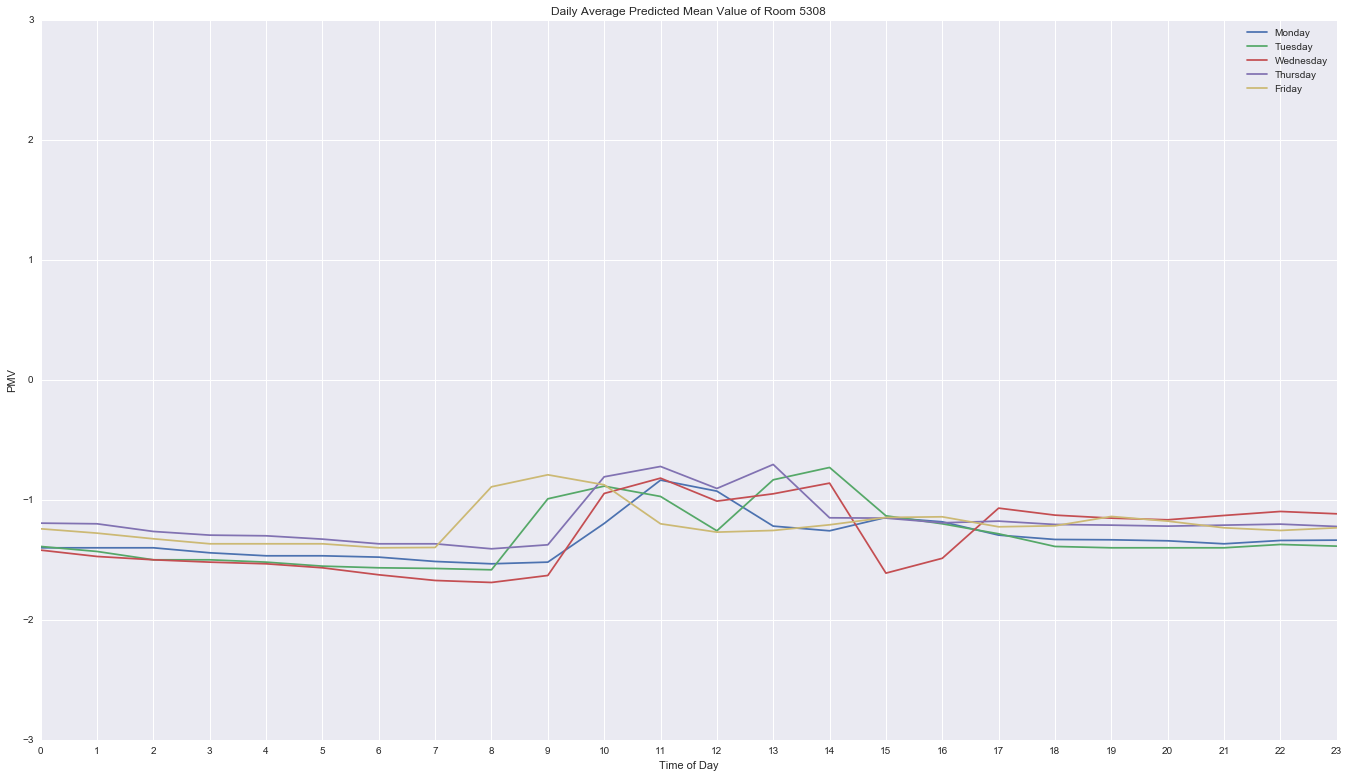

In [605]:
fig = plt.figure(figsize = (18,10))
axes = fig.add_axes([0,0,1,1], title = "Daily Average Predicted Mean Value of Room 5308")
plt.xticks(np.arange(0,24))
# plt.yticks(np.arange(-3,3))

axes.plot(pd.DataFrame(room5308.groupby(["Day of Week", "Hour"])["PMV"].mean()).ix["Monday"])
axes.plot(pd.DataFrame(room5308.groupby(["Day of Week", "Hour"])["PMV"].mean()).ix["Tuesday"])
axes.plot(pd.DataFrame(room5308.groupby(["Day of Week", "Hour"])["PMV"].mean()).ix["Wednesday"])
axes.plot(pd.DataFrame(room5308.groupby(["Day of Week", "Hour"])["PMV"].mean()).ix["Thursday"])
axes.plot(pd.DataFrame(room5308.groupby(["Day of Week", "Hour"])["PMV"].mean()).ix["Friday"])

axes.set_xlabel("Time of Day")
axes.set_ylabel("PMV")
axes.set_xlim(0,23)
# axes.set_ylim(-3,3)

labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

axes.legend(labels, loc = 0)

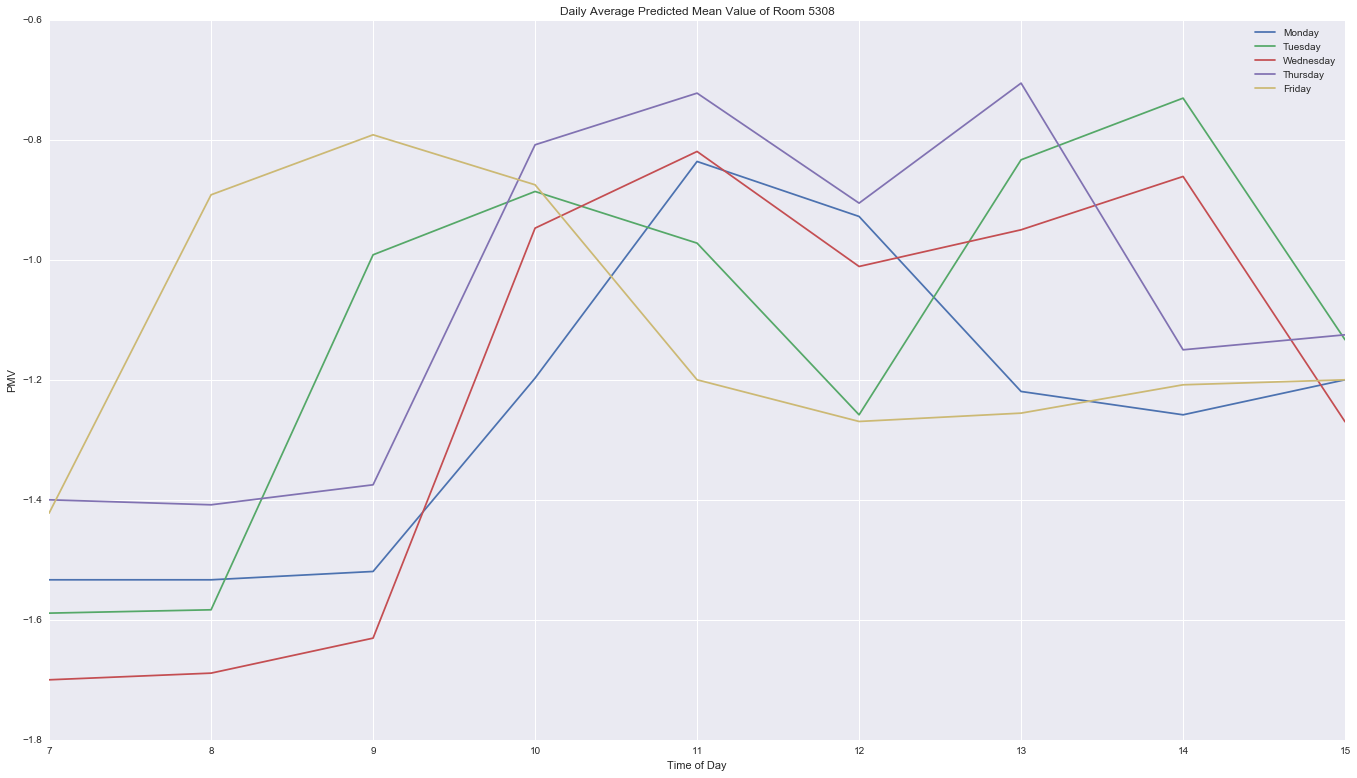

In [666]:
fig = plt.figure(figsize = (18,10))
axes = fig.add_axes([0,0,1,1], title = "Daily Average Predicted Mean Value of Room 5308")
plt.xticks(np.arange(0,24))
# plt.yticks(np.arange(-3,3))

axes.plot(pd.DataFrame(schoolHours.groupby(["Day of Week", "Hour"])["PMV"].mean()).ix["Monday"])
axes.plot(pd.DataFrame(schoolHours.groupby(["Day of Week", "Hour"])["PMV"].mean()).ix["Tuesday"])
axes.plot(pd.DataFrame(schoolHours.groupby(["Day of Week", "Hour"])["PMV"].mean()).ix["Wednesday"])
axes.plot(pd.DataFrame(schoolHours.groupby(["Day of Week", "Hour"])["PMV"].mean()).ix["Thursday"])
axes.plot(pd.DataFrame(schoolHours.groupby(["Day of Week", "Hour"])["PMV"].mean()).ix["Friday"])

axes.set_xlabel("Time of Day")
axes.set_ylabel("PMV")
# axes.set_xlim(7.75,15.25)
# axes.set_ylim(-3,3)

labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

axes.legend(labels, loc = 0)

#### % of Time Acceptable PMV Values

In [659]:
len(room5308[(room5308["PMV"] < .5) & (room5308["PMV"] > - .5)]) / len(room5308)

0.0932625290408231

In [660]:
len(schoolHours[(schoolHours["PMV"] < .5) & (schoolHours["PMV"] > - .5)]) / len(schoolHours)

0.12839325018341893

In [607]:
len(room5308[(room5308["PMV"] > .5) | (room5308["PMV"] < - .5)]) / len(room5308)

0.8987887838062054

In [662]:
len(schoolHours[(schoolHours["PMV"] > .5) | (schoolHours["PMV"] < - .5)]) / len(schoolHours)

0.842993396918562

#### Heatmap of daily PMV averaged hourly

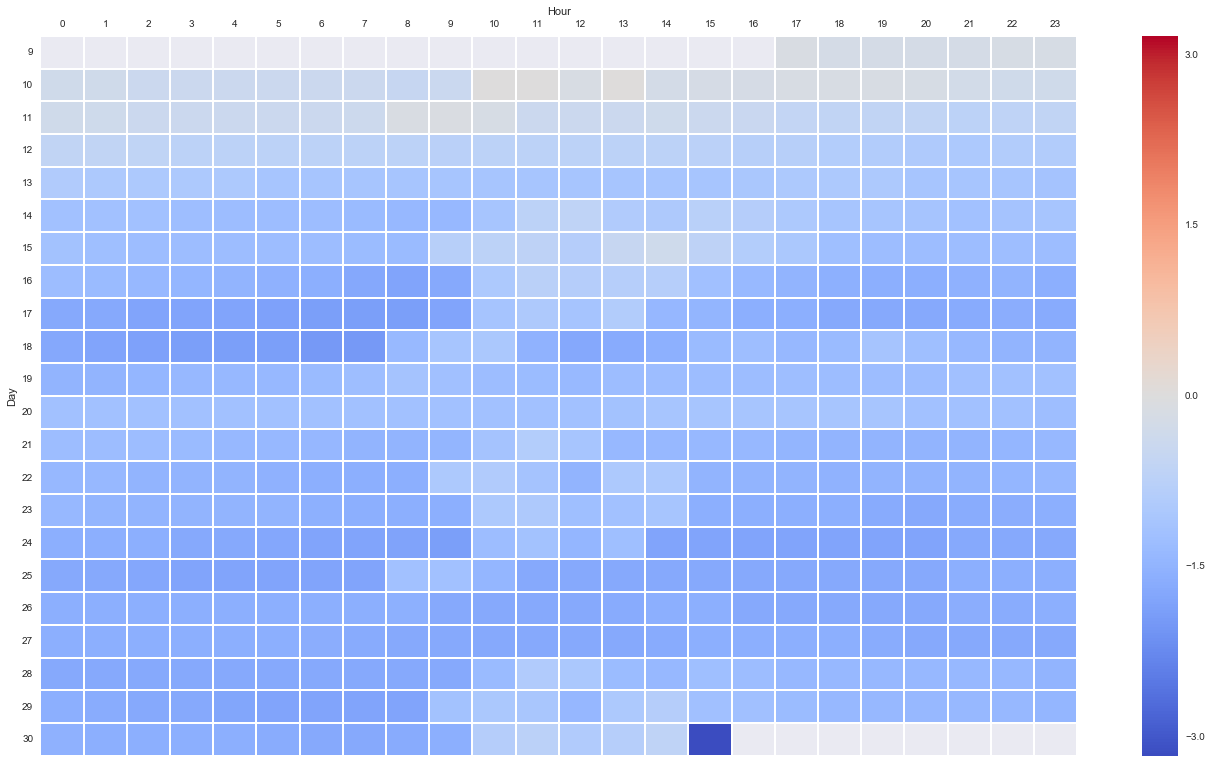

In [604]:
fig = plt.figure(figsize = (18,10))
axes = fig.add_axes([0,0,1,1])


sns.heatmap(room5308.pivot_table(columns = "Hour", index = "Day", values = "PMV", aggfunc = np.mean), 
            center = 0, cmap = "coolwarm", linewidth = 1)


axes.xaxis.set_ticks_position('top')
axes.xaxis.set_label_position('top')
axes.set_yticklabels(axes.yaxis.get_majorticklabels(), rotation=0)